# **import libraries**

In [75]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings
import itertools

# **Load and Display the Dataset**

In [65]:
# Load the dataset
data_path = '/content/owid-covid-data.csv'
data = pd.read_csv(data_path)

# Display the first few rows of the dataset
data.head()


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-08,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-09,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN


## **Data preprocessing**



In [66]:
# Filter data for a specific country (e.g., United States)
country_data = data[data['location'] == 'United States']

# Select relevant columns: date and new_cases
country_data = country_data[['date', 'new_cases']]

# Convert date column to datetime
country_data['date'] = pd.to_datetime(country_data['date'])

# Set the date column as the index
country_data.set_index('date', inplace=True)

# Handle missing values by filling with zero
country_data['new_cases'].fillna(0, inplace=True)

# Prepare data for imputation and model training
data_combined = country_data[['new_cases']]

# Impute missing values
imputer = SimpleImputer(strategy='mean')
data_combined_imputed = pd.DataFrame(imputer.fit_transform(data_combined), columns=data_combined.columns)

# Display the processed data
country_data.head()


,new_cases
date,
2020-01-05,0.0
2020-01-06,0.0
2020-01-07,0.0
2020-01-08,0.0
2020-01-09,0.0


## **Train-Test Split**

In [74]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# **Model Evaluation**

In [73]:
# Predict on the test data
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 5826308142.132207
R-squared: 0.8968440378487512


# **Perform Exploratory Data Analysis (EDA)**

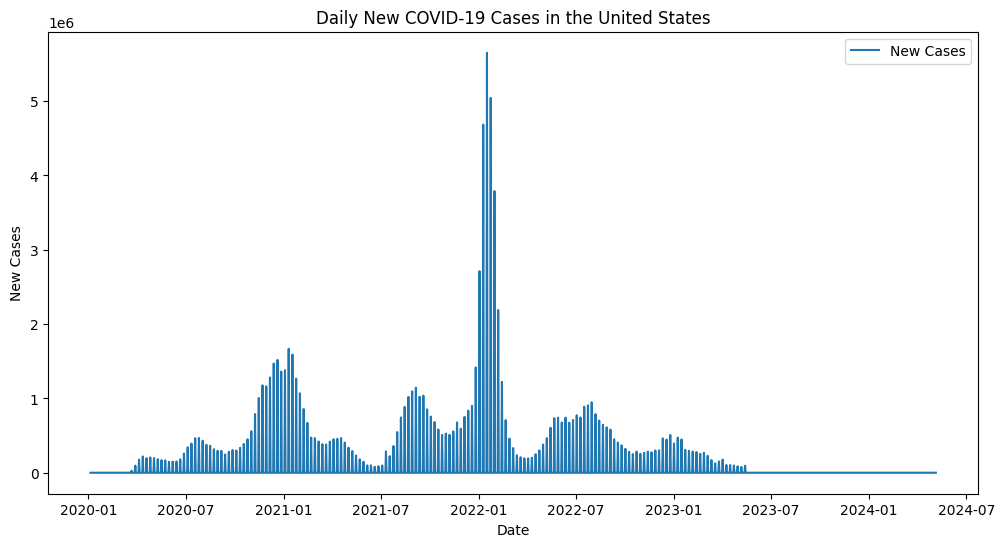

In [27]:
# Plot the new cases over time
plt.figure(figsize=(12, 6))
plt.plot(country_data['new_cases'], label='New Cases')
plt.title('Daily New COVID-19 Cases in the United States')
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.legend()
plt.show()


# **Stationarity Check**

In [28]:
# Perform the Augmented Dickey-Fuller test
result = adfuller(country_data['new_cases'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Differencing to make the series stationary if needed
if result[1] > 0.05:
    country_data['new_cases_diff'] = country_data['new_cases'].diff().dropna()
    result_diff = adfuller(country_data['new_cases_diff'].dropna())
    print('ADF Statistic (Differenced):', result_diff[0])
    print('p-value (Differenced):', result_diff[1])
else:
    country_data['new_cases_diff'] = country_data['new_cases']


ADF Statistic: -3.842805550717238
p-value: 0.002498499793683193


# **Fit the ARIMA Model**

In [29]:
# Define the p, d, q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, d, q triplets
pdq = list(itertools.product(p, d, q))

# Find the best parameters
warnings.filterwarnings("ignore")
aic_values = []
params = []

for param in pdq:
    try:
        model = ARIMA(country_data['new_cases_diff'].dropna(), order=param)
        results = model.fit()
        aic_values.append(results.aic)
        params.append(param)
    except:
        continue

# Find the parameters with minimal AIC value
optimal_params = params[aic_values.index(min(aic_values))]
print(f'Optimal parameters: {optimal_params}')

Optimal parameters: (1, 0, 2)


# **Model Diagnostics**

                               SARIMAX Results                                
Dep. Variable:         new_cases_diff   No. Observations:                 1583
Model:                 ARIMA(1, 0, 2)   Log Likelihood              -22251.446
Date:                Sat, 25 May 2024   AIC                          44512.893
Time:                        15:16:59   BIC                          44539.728
Sample:                    01-05-2020   HQIC                         44522.863
                         - 05-05-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.534e+04   2.62e-09    2.5e+13      0.000    6.53e+04    6.53e+04
ar.L1          0.9857      0.006    157.832      0.000       0.973       0.998
ma.L1         -1.1562      0.018    -65.351      0.0

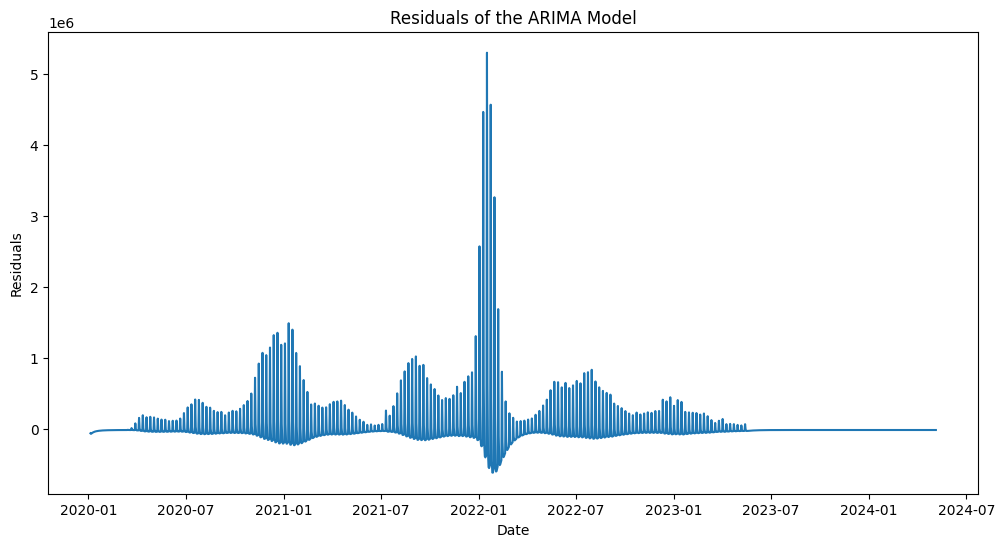

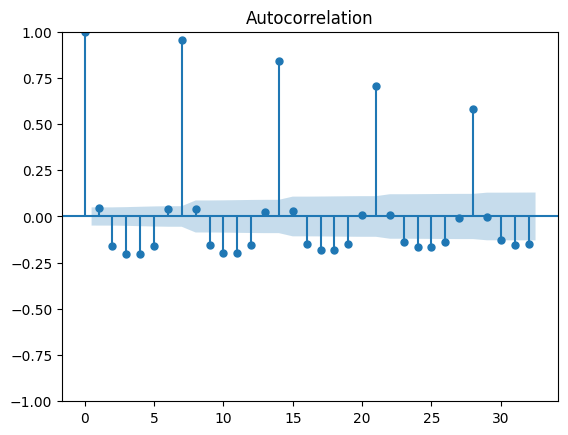

In [30]:
# Fit the ARIMA model with optimal parameters
model = ARIMA(country_data['new_cases_diff'].dropna(), order=optimal_params)
results = model.fit()

# Print model summary
print(results.summary())

# Plot the residuals
residuals = results.resid

plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residuals of the ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

# Plot the ACF of the residuals
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(residuals)
plt.show()


# **Model Forecasting**

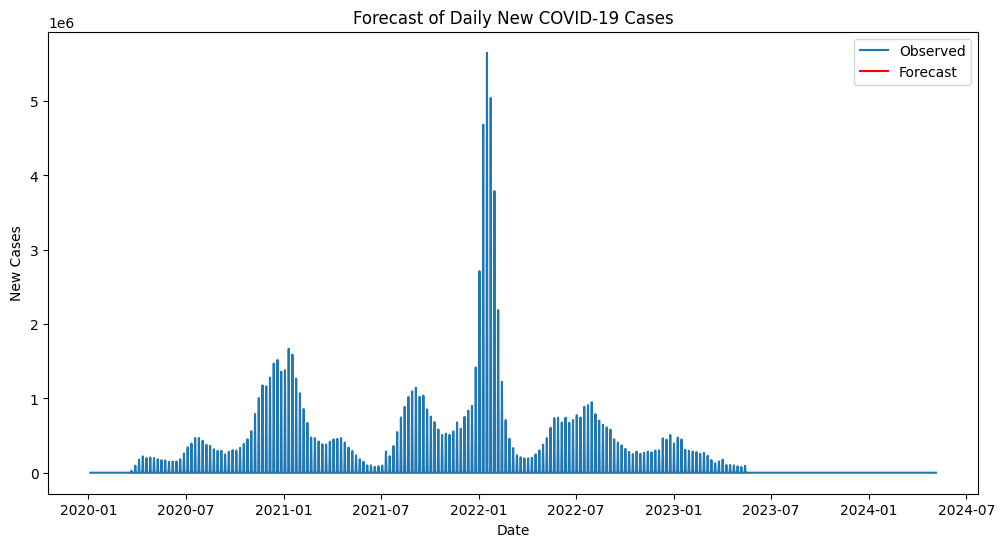

In [45]:
# Forecast the next 30 days
forecast = results.get_forecast(steps=30)
forecast_index = pd.date_range(start=country_data.index[-1], periods=30, freq='D')
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(country_data['new_cases'], label='Observed')
plt.plot(forecast_series, label='Forecast', color='red')
plt.title('Forecast of Daily New COVID-19 Cases')
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.legend()
plt.show()


# **Data Augmentation and Model Optimization**

Best parameters: (0, 1, 2)
Best AIC: 6796.564088124949


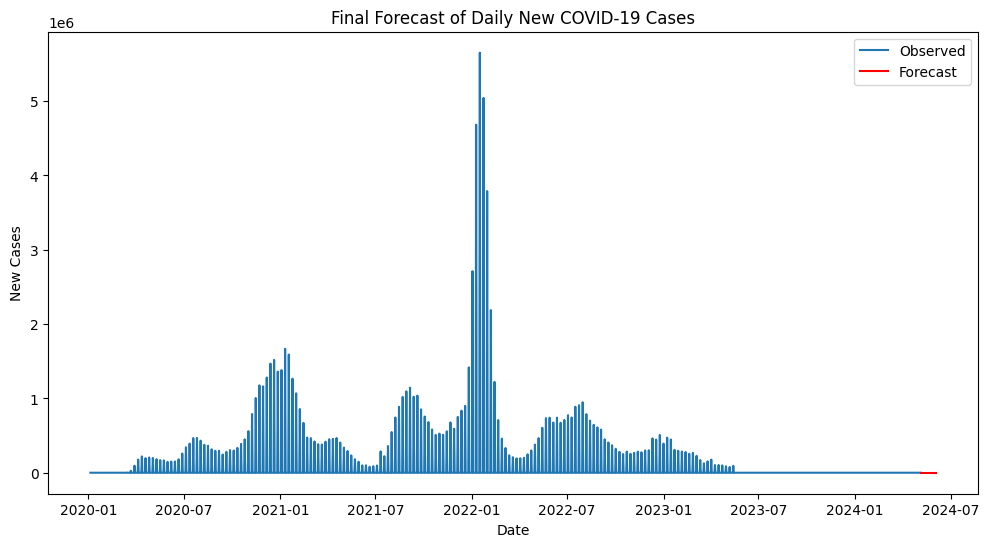

In [32]:
# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)
params_grid = {'p': range(0, 3), 'd': range(0, 3), 'q': range(0, 3)}
best_aic = np.inf
best_params = None
best_model = None

for p in params_grid['p']:
    for d in params_grid['d']:
        for q in params_grid['q']:
            for train_index, test_index in tscv.split(country_data['new_cases_diff'].dropna()):
                train, test = country_data['new_cases_diff'].dropna().iloc[train_index], country_data['new_cases_diff'].dropna().iloc[test_index]
                try:
                    model = ARIMA(train, order=(p, d, q))
                    results = model.fit()
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_params = (p, d, q)
                        best_model = results
                except:
                    continue

print(f'Best parameters: {best_params}')
print(f'Best AIC: {best_aic}')

# Refit the best model on the entire dataset
final_model = ARIMA(country_data['new_cases_diff'].dropna(), order=best_params)
final_results = final_model.fit()

# Forecast using the final model
final_forecast = final_results.get_forecast(steps=30)
final_forecast_series = pd.Series(final_forecast.predicted_mean, index=forecast_index)

# Plot the final forecast
plt.figure(figsize=(12, 6))
plt.plot(country_data['new_cases'], label='Observed')
plt.plot(final_forecast_series, label='Forecast', color='red')
plt.title('Final Forecast of Daily New COVID-19 Cases')
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.legend()
plt.show()
